In [27]:
#https://www.kaggle.com/knowledgegrappler/a-simple-nn-solution-with-keras-0-48611-pl
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection  import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline 

import math


from subprocess import check_output
import os
from os import chdir
print(os.getcwd())


e:\pywork


In [28]:
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    #math.log自然対数関数　, enumerateインデックス番号　省略時は0から始まる
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5

In [32]:
print("Loading data...")
train = pd.read_table("input/train.tsv")
test = pd.read_table("input/test.tsv")
print(train.shape)
print(test.shape)

Loading data...
(1482535, 8)
(693359, 7)


In [33]:
print("Handling missing values...")
#欠損データ処理
def handle_missing(dataset):
    dataset.category_name.fillna(value="missing", inplace=True)
    dataset.brand_name.fillna(value="missing", inplace=True)
    dataset.item_description.fillna(value="missing", inplace=True)
    return (dataset)

train = handle_missing(train)
test = handle_missing(test)
print(train.shape)
print(test.shape)

Handling missing values...
(1482535, 8)
(693359, 7)


In [34]:
train.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,missing,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [36]:
print("Handling categorical variables...")
#分類器にかける前に文字データを離散の数値に変換するときに使われる。
#細かい処理などはできないが、とりあいず離散数値にして分類器にかけたいときによく使います。
le = LabelEncoder()

le.fit(np.hstack([train.category_name, test.category_name]))
train.category_name = le.transform(train.category_name)
test.category_name = le.transform(test.category_name)

le.fit(np.hstack([train.brand_name, test.brand_name]))
train.brand_name = le.transform(train.brand_name)
test.brand_name = le.transform(test.brand_name)
del le
train.head(3)

Handling categorical variables...


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5265,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,86,3889,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,1277,4588,10.0,1,Adorable top with a hint of lace and a key hol...


In [38]:
print("Text to seq process...")
from keras.preprocessing.text import Tokenizer
#配列を結合
raw_text = np.hstack([train.item_description.str.lower(), train.name.str.lower()])

print("   Fitting tokenizer...")
#テキストをベクトル化
tok_raw = Tokenizer()
tok_raw.fit_on_texts(raw_text)
print("   Transforming text to seq...")

#texts_to_sequences:文章を単語のリストに分割
#str.lower(): すべての文字を小文字にする
train["seq_item_description"] = tok_raw.texts_to_sequences(train.item_description.str.lower())
test["seq_item_description"] = tok_raw.texts_to_sequences(test.item_description.str.lower())
train["seq_name"] = tok_raw.texts_to_sequences(train.name.str.lower())
test["seq_name"] = tok_raw.texts_to_sequences(test.name.str.lower())
train.head(3)

Text to seq process...


Using TensorFlow backend.


   Fitting tokenizer...
   Transforming text to seq...


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,seq_item_description,seq_name
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5265,10.0,1,No description yet,"[12, 68, 79]","[3852, 8823, 6896, 208, 84, 6, 155]"
1,1,Razer BlackWidow Chroma Keyboard,3,86,3889,52.0,0,This keyboard is in great condition and works ...,"[29, 2627, 10, 7, 39, 17, 1, 207, 51, 19, 1113...","[10760, 25565, 16369, 2627]"
2,2,AVA-VIV Blouse,1,1277,4588,10.0,1,Adorable top with a hint of lace and a key hol...,"[604, 60, 9, 4, 5347, 11, 192, 1, 4, 886, 1290...","[7634, 10563, 666]"


In [39]:
#SEQUENCES VARIABLES ANALYSIS
max_name_seq = np.max([np.max(train.seq_name.apply(lambda x: len(x))), np.max(test.seq_name.apply(lambda x: len(x)))])
max_seq_item_description = np.max([np.max(train.seq_item_description.apply(lambda x: len(x)))
                                   , np.max(test.seq_item_description.apply(lambda x: len(x)))])
print("max name seq "+str(max_name_seq))
print("max item desc seq "+str(max_seq_item_description))

max name seq 17
max item desc seq 269


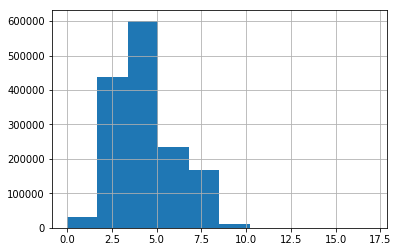

In [40]:
train.seq_name.apply(lambda x: len(x)).hist()

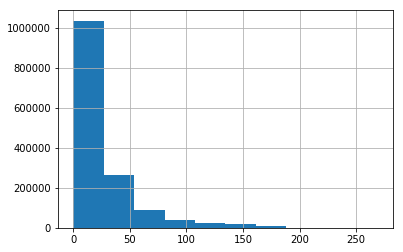

In [41]:
train.seq_item_description.apply(lambda x: len(x)).hist()

In [42]:
#EMBEDDINGS MAX VALUE
#Base on the histograms, we select the next lengths
MAX_NAME_SEQ = 10
MAX_ITEM_DESC_SEQ = 75
MAX_TEXT = np.max([np.max(train.seq_name.max())
                   , np.max(test.seq_name.max())
                  , np.max(train.seq_item_description.max())
                  , np.max(test.seq_item_description.max())])+2
MAX_CATEGORY = np.max([train.category_name.max(), test.category_name.max()])+1
MAX_BRAND = np.max([train.brand_name.max(), test.brand_name.max()])+1
MAX_CONDITION = np.max([train.item_condition_id.max(), test.item_condition_id.max()])+1
#SCALE target variable
train["target"] = np.log(train.price+1)
target_scaler = MinMaxScaler(feature_range=(-1, 1))
train["target"] = target_scaler.fit_transform(train.target.reshape(-1,1))
pd.DataFrame(train.target).hist()

AttributeError: 'Series' object has no attribute 'reshape'